In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

Datasets should be located in the folder /kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/
(That's where they get imported in Kaggle so we'll use the same folder even if working locally)

In [24]:
# Input data files are available in the read-only "../input/" directory
# For example, run this function to list all input files

def listDatasetFiles():
    for dirname, _, filenames in os.walk('kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

In [25]:
# Import defog
path = "kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog"

defog_dfs = {} # Dictionary of filename:dataframe pairs

for file in os.listdir(path):  # For now we just use 1 csv
    print(file)
    filename = os.path.splitext(file)[0] # Get only the filename without extension
    df = pd.read_csv( os.path.join(path,file) )
    defog_dfs[filename] = df

02ea782681.csv
06414383cf.csv
092b4c1819.csv
0c55be4384.csv
0d7ab3a9f9.csv
0eaac04f17.csv
0ec76d2d8e.csv
139f60d29b.csv
13a4fe5159.csv
15508c7f41.csv
18e7abc37e.csv
1d99c2eecf.csv
1ff78d55e9.csv
28209b9006.csv
2a01c919c0.csv
2b6a1c294a.csv
2c12284ed2.csv
2e75cf4507.csv
32843e32b6.csv
32d03020a9.csv
38befe9f39.csv
3e6987cb2d.csv
3f3b08f78d.csv
3f970065e5.csv
41bc215f97.csv
4520cf1068.csv
4c0aec9035.csv
4c3aa8ea6e.csv
4ec23c3d98.csv
4f613ccf88.csv
509a9830a6.csv
519f292daa.csv
5327e062c9.csv
54c6a21be6.csv
5f7c0cfbb5.csv
6041cad8ec.csv
62d4a42a73.csv
64b8429f83.csv
68e7e02a47.csv
6a20935af5.csv
6c300fcdd5.csv
6dc94db321.csv
7030643376.csv
771d69d829.csv
77d7d95074.csv
7a467da4f3.csv
7a993fbed7.csv
7b5346a3f2.csv
8282009100.csv
850748a138.csv
88c6d288fb.csv
8d2d863dfd.csv
8db3a7e46b.csv
8e5d9c4e16.csv
95e9824e15.csv
961b782275.csv
97e44fa8c3.csv
9f2b3555c8.csv
a057215d88.csv
a2f1a8ab76.csv
a8c5a489bd.csv
aafcbecb5a.csv
afaec39b8c.csv
afc4b9d2a8.csv
b3891f42d0.csv
b4365bba9d.csv
bdcff4be3a

# General overview of data

In [26]:
df = list(defog_dfs.values())[0]  # Show dataframe of the first csv loaded
df

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.000000,0.044129,-0.250000,0,0,0,False,False
1,1,-1.000000,0.034431,-0.250000,0,0,0,False,False
2,2,-1.000000,0.031250,-0.250000,0,0,0,False,False
3,3,-1.000000,0.031250,-0.250000,0,0,0,False,False
4,4,-1.000000,0.031250,-0.250000,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...
162902,162902,-1.007283,0.234375,-0.375000,0,0,0,False,False
162903,162903,-1.000000,0.234375,-0.369159,0,0,0,False,False
162904,162904,-0.994626,0.234375,-0.351954,0,0,0,False,False
162905,162905,-0.977308,0.234375,-0.336683,0,0,0,False,False


In [27]:
df.dtypes

Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid                 bool
Task                  bool
dtype: object

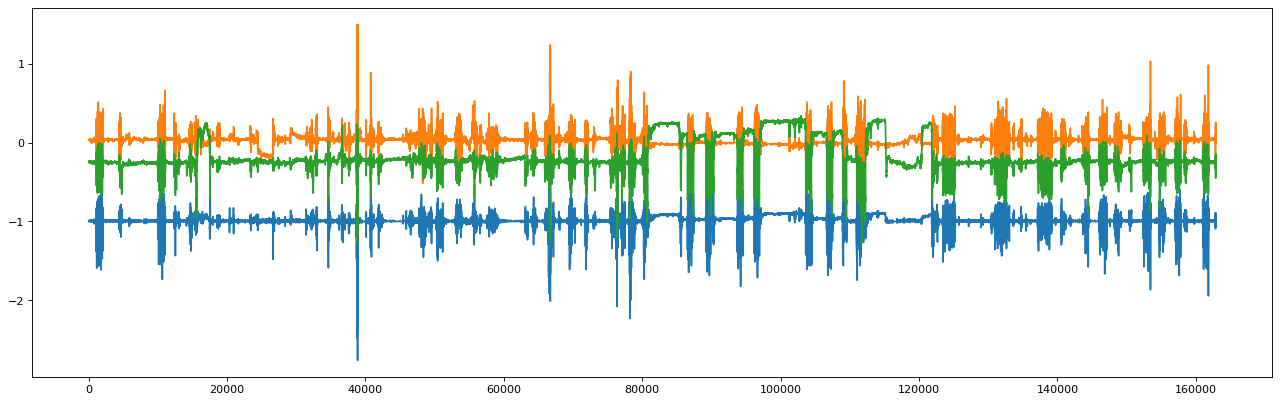

In [28]:
# Plot accelerations
plt.figure(figsize=(20, 6), dpi=80)

x = np.arange(len(df))
y = np.array(df.AccV)
plt.plot(x, y)
y = np.array(df.AccML)
plt.plot(x, y)
y = np.array(df.AccAP)
plt.plot(x, y)




# Data cleaning
Clean erroneous data: typos, impossible values, missing values, etc

In [29]:
# Run this function to check what needs to be cleaned, and run it again after cleaning to ensure there's nothing else to clean

def doesDfNeedCleaning(df):
    """ Returns true if the dataset doesn't need more cleaning """
    
    ## Time ## 
    assert(df.Time[0] == 0)                 # Must start from 0
    assert(df.Time.is_monotonic_increasing) # Must always increase by 1 (before we drop any rows)

    
    ## AccV, AccML, AccAP ##
    
    # Check for NaNs
    assert(df.AccV.isna().sum() == 0)
    assert(df.AccML.isna().sum() == 0)
    assert(df.AccAP.isna().sum() == 0)
    
    #Suspicious 0s --> TODO: There are some csvs with lots of 0s but we're still unsure whether they're invalid data or just normal accelerometer output
    #assert(0 not in df.AccV.values)
    #assert(0 not in df.AccML.values)
    #assert(0 not in df.AccAP.values)

    # Suspicious very precise numbers (-1, etc)
    # TODO

    # Check that max accels are not ridiculous. Should not be above 4g
    # See https://en.wikipedia.org/wiki/G-force#Human_tolerance_of_g-force
    # (with a little extra tolerance because if we clip it at an exact value, comparing floats is tricky)
    assert( df.AccV.abs().max()  < 4.1 )
    assert( df.AccML.abs().max() < 4.1 )
    assert( df.AccAP.abs().max() < 4.1 )
    
    
    ## StartHesitation, Turn, Walking ##
    
    #Only 0 or 1
    assert( df.StartHesitation.isin([0,1]).all() )
    assert( df.Turn.isin([0,1]).all() )
    assert( df.Walking.isin([0,1]).all()  )
    
    # Only one of the three can be 1 per row
    assert(len( df[df.StartHesitation + df.Turn + df.Walking > 1] ) == 0)
    
    
    ## Valid, Task ##
    
    #Only true or false
    assert( df.Valid.isin([True,False]).all() )
    assert( df.Task.isin([True,False]).all() )



In [30]:
def cleanDF(df):
    """ Performs cleaning on a dataframe (only the operations that we found were needed) """
    
    # Clamp acceleration values to realistic values
    df.AccV.clip(-4,4, inplace=True)
    df.AccML.clip(-4,4, inplace=True)
    df.AccAP.clip(-4,4, inplace=True)


In [31]:
# Clean all the dataframes
for id in defog_dfs.keys():
    cleanDF(defog_dfs[id])

In [32]:
# Confirm all DFs are clean
for id in defog_dfs.keys():
    print(id) # Print each id. In case of error found, we'll see where it is
    doesDfNeedCleaning(defog_dfs[id])
print("Data is clean. It's ok to proceed.") # Will reach this line if no errors found

02ea782681
06414383cf
092b4c1819
0c55be4384
0d7ab3a9f9
0eaac04f17
0ec76d2d8e
139f60d29b
13a4fe5159
15508c7f41
18e7abc37e
1d99c2eecf
1ff78d55e9
28209b9006
2a01c919c0
2b6a1c294a
2c12284ed2
2e75cf4507
32843e32b6
32d03020a9
38befe9f39
3e6987cb2d
3f3b08f78d
3f970065e5
41bc215f97
4520cf1068
4c0aec9035
4c3aa8ea6e
4ec23c3d98
4f613ccf88
509a9830a6
519f292daa
5327e062c9
54c6a21be6
5f7c0cfbb5
6041cad8ec
62d4a42a73
64b8429f83
68e7e02a47
6a20935af5
6c300fcdd5
6dc94db321
7030643376
771d69d829
77d7d95074
7a467da4f3
7a993fbed7
7b5346a3f2
8282009100
850748a138
88c6d288fb
8d2d863dfd
8db3a7e46b
8e5d9c4e16
95e9824e15
961b782275
97e44fa8c3
9f2b3555c8
a057215d88
a2f1a8ab76
a8c5a489bd
aafcbecb5a
afaec39b8c
afc4b9d2a8
b3891f42d0
b4365bba9d
bdcff4be3a
bdda73c9be
be15a0d6c5
be9d33541d
bf2fd0ff35
c50f164e00
c7f06a72e7
d59b65430b
d99c7b2069
da05ad7058
daa4d27db4
dd0ddc0bb5
e069a57511
e1f92471b9
e642d9ea5f
e971ae2a09
edd79a7494
f0b8335d50
f17eacf7d8
f2ffe15369
f3a921edee
f40e8c6ebe
f8ddbdd98d
f9efef91fb
f9fc61ce85

# Data wrangling
 Convert data to a more usable format and optimize it for faster processing.

In [33]:
list(defog_dfs.values())[0].head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task
0,0,-1.0,0.044129,-0.25,0,0,0,False,False
1,1,-1.0,0.034431,-0.25,0,0,0,False,False
2,2,-1.0,0.031250,-0.25,0,0,0,False,False
3,3,-1.0,0.031250,-0.25,0,0,0,False,False
4,4,-1.0,0.031250,-0.25,0,0,0,False,False


In [34]:
list(defog_dfs.values())[0].dtypes

Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid                 bool
Task                  bool
dtype: object

In [35]:
def applyDataWrangling(df):
    
    # Time should easily fit into an int32 (max value is 2 billion)
    df['Time'] = df['Time'].astype(np.int32)
    
    # We can use Time as the index
    # Warning! This would not work if we had deleted rows during data cleaning!
    df.set_index("Time", inplace=True)
    
    # Convert StartHesitation, Turn & Walking to bool
    df['StartHesitation'] = df['StartHesitation'].astype('bool')
    df['Turn'] = df['Turn'].astype('bool')
    df['Walking'] = df['Walking'].astype('bool')


    #Data series in the DeFOG dataset are annotated with Valid and Task labels. Only the portions of the series where both are true should you consider to be annotated. Though not included in the test set, the metric is aware of these labels and will ignore predictions on the unannotated portions of these series (where either label is false).
    #Valid: There were cases during the video annotation that were hard for the annotator to decide if there was an akinetic (i.e. no movement) FoG or the subject stopped voluntarily. Only event annotations where Valid is true should be considered as unambiguous.
    #Task: series were only annotated where this value is true. Portions marked false should be considered unannotated.
    #In summary: rows with Valid==false or Task==false are useless. StartHesitation, Turn & Walking can be set to 0 to prevent confusion.
    df.loc[~df.Valid | ~df.Task, 'StartHesitation'] = False
    df.loc[~df.Valid | ~df.Task, 'Turn'] = False
    df.loc[~df.Valid | ~df.Task, 'Walking'] = False
    
    # Warning: Valid==false actually means 'ambiguous'. We could still use the 1s but we would have to take the uncertainity into account, somehow. 

In [36]:
for id in defog_dfs.keys():
    applyDataWrangling(defog_dfs[id])

# Feature engineering

In [37]:
def applyFeatureEngineering(df):    
    
    # tdcsfog and defog run at different frequency, therefore Time column is not reliable.
    # Here we build a timestamp column with the real time. Time [s] = frameIndex / frequency [Hz]
    df["timestamp"] = df.index / 100.0

    # I don't recommend using timestamp as index instead of Time because using floats as index might cause problems.
    # See: https://stackoverflow.com/questions/29237678/pandas-series-float-index
    
    
    # TODO: Maybe use rolling mean/filtered/smoothed acceleration columns to deal with accelerometer noise
    
    
    # TODO: Decide which acceleration unit to use (m/s^2 VS g). If we use the former, we need to convert defog to m/s^2")
    G0 = 9.80665
    df['AccV']  = df['AccV']  * G0
    df['AccML'] = df['AccML'] * G0
    df['AccAP'] = df['AccAP'] * G0
    
    
    
    
    ###################################### Ana's section
    # Create a Pitagoras sum column
    #     d = sqrt(Vx^2 + Vy^2 + Vz^2)
    df['sum'] = df['AccV']**2 + df['AccML']**2 + df['AccAP']**2
    df['sum'] = df['sum'] ** 0.5   # We apply sqrt like this because we can't use math.sqrt with df columns
    
    
    # Create jerk column (derivate of the acceleration). We derive from the sum acceleration
    # To derivate, we take the current acc minus the previous acc, divided by the elapsed time
    df['jerk'] = df['sum'].diff() / df['timestamp'].diff()
    

In [38]:
# Apply feature engineering to all dataframes
for id in defog_dfs.keys():
    applyFeatureEngineering(defog_dfs[id])

In [39]:
# Print first df to confirm it looks ok
list(defog_dfs.values())[0]

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,timestamp,sum,jerk
Time,,,,,,,,,,,
0,-9.806650,0.432762,-2.451662,False,False,False,False,False,0.00,10.117723,NaN
1,-9.806650,0.337656,-2.451662,False,False,False,False,False,0.01,10.114101,-0.362159
2,-9.806650,0.306458,-2.451662,False,False,False,False,False,0.02,10.113108,-0.099348
3,-9.806650,0.306458,-2.451662,False,False,False,False,False,0.03,10.113108,0.000000
4,-9.806650,0.306458,-2.451662,False,False,False,False,False,0.04,10.113108,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
162902,-9.878075,2.298434,-3.677494,False,False,False,False,False,1629.02,10.788101,-9.748471
162903,-9.806650,2.298434,-3.620212,False,False,False,False,False,1629.03,10.703229,-8.487194
162904,-9.753950,2.298434,-3.451493,False,False,False,False,False,1629.04,10.598827,-10.440205


In [40]:
list(defog_dfs.values())[0].dtypes

AccV               float64
AccML              float64
AccAP              float64
StartHesitation       bool
Turn                  bool
Walking               bool
Valid                 bool
Task                  bool
timestamp          float64
sum                float64
jerk               float64
dtype: object

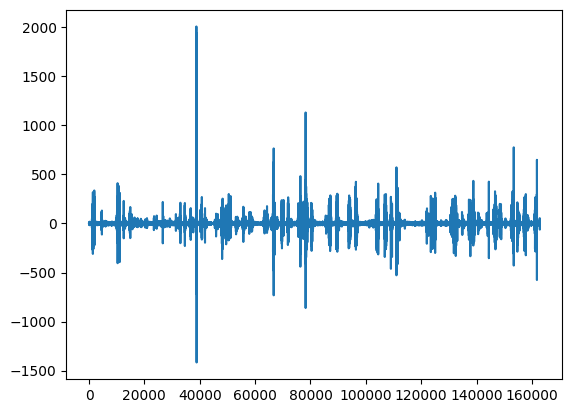

In [41]:
# Plot accelerations
x = np.arange(len(df))

#y = np.array(df['sum'])
#plt.plot(x, y)

y = np.array(df['jerk'])
plt.plot(x, y)

# Add metadata columns

## TaskName

Each test (represented as one of the CSVs in tdcsfog and unfog) consists of a sequence of many different exercises (walk, sit, turn around...).

The file tasks.csv tells us, for each test, when do these exercises start and end. We can add a new column with this information.

Caution! We already have a boolean Task column, so we'll call the new column 'TaskName'.

In [42]:
df_tasks = pd.read_csv("kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tasks.csv")
df_tasks.head(3)

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2
2,02ab235146,505.88,522.40,4MW


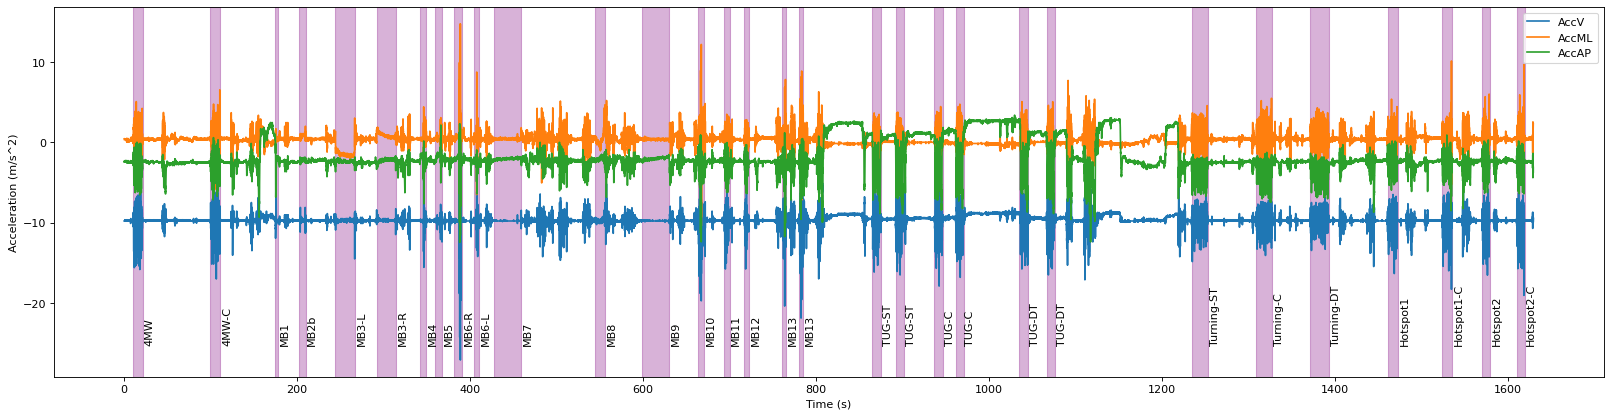

In [47]:
# Plot accelerations for the 1st CSV, now with colored areas for each exercise
for id, df in list(defog_dfs.items())[:1]:
    
    plt.figure(figsize=(25, 6), dpi=80)
    x = np.array(df.timestamp)
    y = np.array(df.AccV)
    plt.plot(x, y, label='AccV')
    y = np.array(df.AccML)
    plt.plot(x, y, label='AccML')
    y = np.array(df.AccAP)
    plt.plot(x, y, label='AccAP')
    
    plt.ylabel('Acceleration (m/s^2)')
    plt.xlabel('Time (s)')
    plt.legend()
    
    # Paint background bars
    df_tasks_singleId = df_tasks[df_tasks["Id"]==id] # Filter df_tasks by a single Id

    for i,row in df_tasks_singleId.iterrows():
        plt.axvspan(row.Begin, row.End, alpha=0.3, color='purple')
        plt.text(x=row.End+2, y=-25, s=row.Task, rotation='vertical')

In order to feed the current activity to the AI model, we need to have a new column.

Note that we already had a boolean Task column so we'll name the new one 'TaskName'.

In [44]:
%%time

for id in list(defog_dfs.keys()):
    
    # Out of all the rows in tasks.csv, we want only those for this particular Id
    df_tasks_singleId = df_tasks[df_tasks["Id"]==id]
    
    defog_dfs[id]["TaskName"] = "-"
    
    for i, row in df_tasks_singleId.iterrows():
        defog_dfs[id].loc[(defog_dfs[id].timestamp > row.Begin) & (defog_dfs[id].timestamp < row.End), "TaskName"] = row.Task

CPU times: total: 2.33 s
Wall time: 2.38 s


In [45]:
# Check 1st dataframe to see if Taskname column is ok
list(defog_dfs.values())[0].head()

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,timestamp,sum,jerk,TaskName
Time,,,,,,,,,,,,
0,-9.80665,0.432762,-2.451662,False,False,False,False,False,0.00,10.117723,NaN,-
1,-9.80665,0.337656,-2.451662,False,False,False,False,False,0.01,10.114101,-0.362159,-
2,-9.80665,0.306458,-2.451662,False,False,False,False,False,0.02,10.113108,-0.099348,-
3,-9.80665,0.306458,-2.451662,False,False,False,False,False,0.03,10.113108,0.000000,-
4,-9.80665,0.306458,-2.451662,False,False,False,False,False,0.04,10.113108,0.000000,-


In [46]:
# Same, but filter rows with '-'
list(defog_dfs.values())[0][df.TaskName != '-']

,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,timestamp,sum,jerk,TaskName
Time,,,,,,,,,,,,
1001,-9.653421,0.436363,-2.604891,False,False,False,True,True,10.01,10.008217,12.687918,4MW
1002,-9.653421,0.284552,-2.604891,False,False,False,True,True,10.02,10.002748,-0.546912,4MW
1003,-9.653421,0.153229,-2.604891,False,False,False,True,True,10.03,9.999874,-0.287417,4MW
1004,-9.656311,0.150339,-2.604891,False,False,False,True,True,10.04,10.002620,0.274575,4MW
1005,-9.806650,0.001484,-2.604891,False,False,False,True,True,10.05,10.146716,14.409640,4MW
...,...,...,...,...,...,...,...,...,...,...,...,...
161902,-9.653421,0.459687,-2.298434,False,False,False,True,True,1619.02,9.933914,0.000000,Hotspot2-C
161903,-9.653421,0.459687,-2.298434,False,False,False,True,True,1619.03,9.933914,0.000000,Hotspot2-C
161904,-9.806233,0.612499,-2.298434,False,False,False,True,True,1619.04,10.090598,15.668364,Hotspot2-C


# Save processed dataset